In [1]:
import gzip
import json
from datasets import load_dataset, Dataset, concatenate_datasets
import markdownify
import re

# original: https://huggingface.co/datasets/its5Q/resh-edu
jsonfilename = "./verbalist/datasets/resh_edu/raw.jsonl.gz"

with gzip.open(jsonfilename, "rb") as f:
    # data = json.loads(f.read().decode('utf-8'))
    data = f.read().decode("utf-8")

dataset = []

for line in data.split("\n"):
    try:
        lesson = json.loads(line)
        dataset.append(lesson)
    except:
        pass

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(dataset)

7260

In [2]:
dataset[0]

{'id': 627,
 'format': 'old',
 'subject': 'География',
 'title': 'Географические карты',
 'author': 'Куликова Екатерина Сергеевна',
 'grade': 5,
 'summary': '<div class="lesson-video__conspectus">\n        <p><strong>Цель</strong>: формирование представления о географическпх картах.</p>\r\n<p><strong>Задачи</strong>:</p>\r\n<p>1. Способствовать формированию представления о географических картах.</p>\r\n<p><strong>Планируемые результаты обучения</strong>:</p>\r\n<p><strong>Личностные:</strong> Готовность обучающихся к саморазвитию и личностному самоопределению. Формирование мотивации к обучению и целенаправленной познавательной деятельности.</p>\r\n<p><strong>Метапредметные:</strong> Освоение обучающимися межпредметных понятий и универсальных учебных действий. Способность их применения в учебной, познавательной и социальной практике.</p>\r\n<p><strong>Предметные:</strong> Формирование представлений о географических картах.</p>\r\n<p><strong>Ход урока</strong>:</p>\r\n<p><strong>Этап мот

In [ ]:
def pretty_lesson(html):
    text = str(markdownify.markdownify(html))
    text = re.sub(r"!\[\]\(.*\)", "", text)
    text = re.sub(r"\[.*\]\(.*\)", "", text)
    text = text.replace("\n\n", "\n")
    return text


text = pretty_lesson(dataset[0]["summary"])
print(text)

In [ ]:
dataset[0]

In [42]:
from tqdm import tqdm

new_dataset = []

for item in tqdm(dataset):
    if "summary" in item:
        subject = item["subject"]
        title = item["title"]
        grade = item["grade"]
        prompt = (
            f"Напиши план урока\nПредмет: {subject}\nТема: {title}\nКласс: {grade}\n"
        )
        summary = item["summary"]
        summary = pretty_lesson(summary)
        if len(summary) > 0:
            new_dataset.append(
                {
                    "solution": summary,
                    "prompt": prompt,
                }
            )

100%|██████████| 7260/7260 [00:46<00:00, 155.46it/s]


In [43]:
print(new_dataset[200]["prompt"])
print(new_dataset[200]["solution"])

Напиши план урока
Предмет: Английский язык
Тема: Множественное число имён существительных. Указательные местоимения this/that, these/those
Класс: 5


**Цели урока:** 

 Актуализировать грамматический материал по темам «Множественное число имён существительных», «Указательные местоимения this/that, these/those» на базе активной лексики модуля «Будем знакомы!».

**Предметные результаты:** 

* распознавание и употребление в речи изучаемых грамматических форм;
* умение действовать по образцу при выполнении упражнений.

**Метапредметные и личностные результаты**

*Личностные УУД:*

* формирование ответственного отношения к учению;
* формирование коммуникативной компетентности в общении и сотрудничестве со сверстниками.

*Регулятивные УУД:*

* умение самостоятельно определять цель учебной деятельности (формулировка и принятие учебных задач урока);
* умение оценивать правильность выполнения учебной задачи, собственные возможности её решения;
* оценка - выделение и осознание учащимся того, что

100%|██████████| 6382/6382 [00:42<00:00, 150.95it/s]


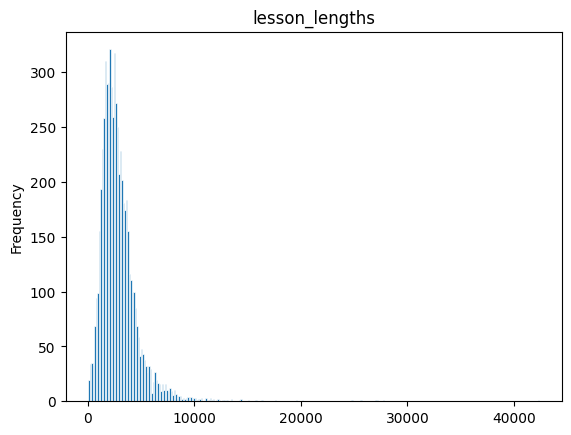

In [44]:
from transformers import AutoTokenizer
from verbalist.datasets.utils import visualize_hist

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

conversation_lengths = []


for item in tqdm(new_dataset):
    text = item["prompt"] + item["solution"]
    conversation_lengths.append(len(tokenizer(text)["input_ids"]))
    # print(all_text)
    # print("="*100)
    # print("="*100)
    # print("="*100)
    # break
    # if has_cyrillic(all_text):
    #     rus_conv.append(conversation)


visualize_hist(conversation_lengths, "lesson_lengths")

In [47]:
import numpy as np

filter_num = 33
np.percentile(conversation_lengths, filter_num)

2028.73

In [48]:
sum(np.array(conversation_lengths) < np.percentile(conversation_lengths, filter_num))

2106

In [49]:
short_dataset = []
short_examples = (np.array(conversation_lengths) < np.percentile(conversation_lengths, filter_num)).tolist()
for i, is_short in enumerate(short_examples):
    if is_short:
       short_dataset.append(new_dataset[i]) 

In [50]:
len(short_dataset)

2106

In [51]:
short_dataset[0]

{'solution': '\n**Цели:** формирование рецептивных и продуктивных навыков по теме, изучение основной информации о великом писателе А. П. Чехове и знакомство с одним из его произведений в переводе на английский язык, развитие умений представлять свою культуру на английском языке.\n\n**Задачи урока:** \n\n• формирование навыков чтения и аудирования с целью извлечения полной и запрашиваемой информации;\n\n• автоматизация новых ЛЕ, словообразование;\n\n• воспитание интереса к чтению на иностранном языке;\n\n**Планируемые результаты**\n\n**Предметные:** узнают в письменном и устном тексте, воспроизводит и употребляет в речи лексику по разделу «Время сказок». Формулирует эмоционально-оценочные суждения.\n\n**Метапредметные:** развивают коммуникативные УУД через говорение и чтение, овладевают навыками работы с информацией.\n\n**Личностные:** осознают возможность расширения кругозора посредством чтения на иностранном языке.\n\n**УУД:**\n\n**Познавательные:** проявлять интерес к самостоятельном

In [52]:
short_dataset = Dataset.from_list(short_dataset)
short_dataset

Dataset({
    features: ['solution', 'prompt'],
    num_rows: 2106
})

In [53]:
short_dataset.push_to_hub("dim/resh_edu_short_prompts")

Pushing dataset shards to the dataset hub: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it]


In [56]:
from datasets import load_dataset

dataset = load_dataset("dim/resh_edu_short_prompts")
dataset = dataset["train"]
dataset[0]

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 287.10it/s]


Dataset parquet downloaded and prepared to /home/kosenko/.cache/huggingface/datasets/dim___parquet/dim--resh_edu_short_prompts-92c18e50d0201f4d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 806.13it/s]


{'solution': '\n**Цели:** формирование рецептивных и продуктивных навыков по теме, изучение основной информации о великом писателе А. П. Чехове и знакомство с одним из его произведений в переводе на английский язык, развитие умений представлять свою культуру на английском языке.\n\n**Задачи урока:** \n\n• формирование навыков чтения и аудирования с целью извлечения полной и запрашиваемой информации;\n\n• автоматизация новых ЛЕ, словообразование;\n\n• воспитание интереса к чтению на иностранном языке;\n\n**Планируемые результаты**\n\n**Предметные:** узнают в письменном и устном тексте, воспроизводит и употребляет в речи лексику по разделу «Время сказок». Формулирует эмоционально-оценочные суждения.\n\n**Метапредметные:** развивают коммуникативные УУД через говорение и чтение, овладевают навыками работы с информацией.\n\n**Личностные:** осознают возможность расширения кругозора посредством чтения на иностранном языке.\n\n**УУД:**\n\n**Познавательные:** проявлять интерес к самостоятельном